                     0   1   2   3   4   5   6   7   8   9   ...  49  50  51  \
Blake Griffin        16  16  16  16  15  17  15  13  14  13  ...   0   0   0   
Mike Muscala          4   4   4   4   4   4   4   4   3   5  ...   2   2   2   
Derrick White        70  70  70  70  69  65  62  53  43  31  ...   3   3   3   
Luke Kornet           0   0   0   0   1   2   6  10  19  33  ...   2   2   2   
Mfiondu Kabengele     0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
Grant Williams       23  23  23  23  24  25  37  47  57  61  ...   6   5   5   
Payton Pritchard      3   3   3   3   3   4   4   5   8  13  ...   0   0   0   
Justin Champagnie     0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
Sam Hauser            8   8   8   8   8  10  18  24  33  50  ...   1   1   1   
JD Davison            0   0   0   0   0   0   1   1   1   1  ...   0   0   0   
Al Horford           63  63  63  63  62  60  59  54  39  15  ...   5   7   8   
Jaylen Brown         67  67  67  67  67 

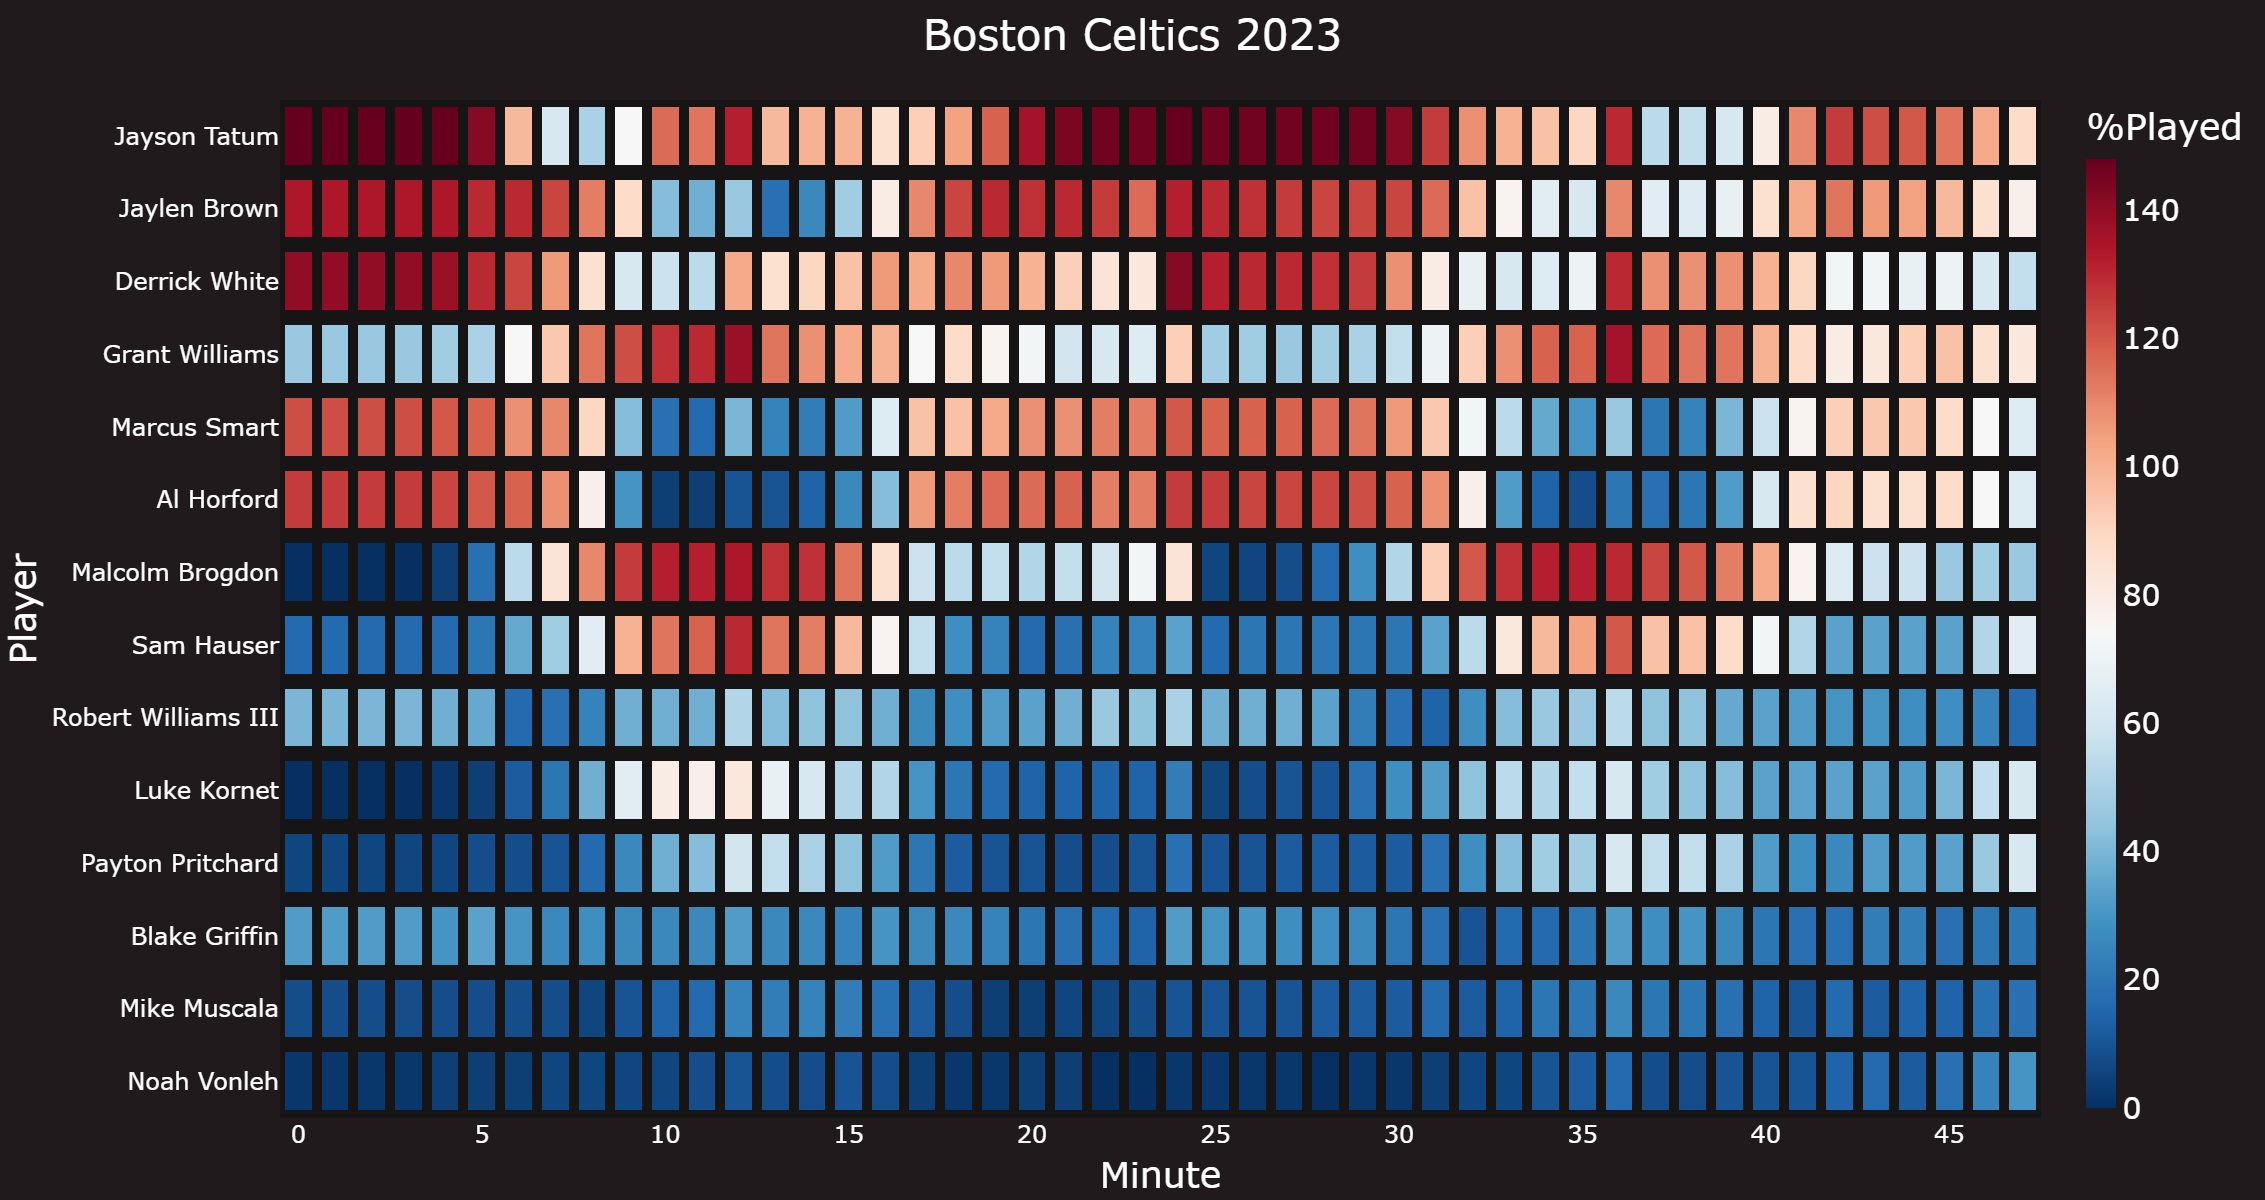

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nba_api.stats.static import players,teams
import plotly.graph_objects as go

def update_matrices(row):
    player = row['Player']
    start_minute = row['start']
    end_minute = row['end']
    plus_minus = row['PT_DIFF']

    # Increment the matrix based on player on-court times
    minutes_played_matrix.loc[player, start_minute:end_minute] += 1

    # Increment the plus_minus_matrix based on player on-court times
    plus_minus_matrix.loc[player, start_minute:end_minute] += plus_minus

def graph_rotation(team,year):
    team = team.upper()

    nba_teams = teams.get_teams()
    team_list= {}
    full_name = {}
    for org in nba_teams:
        team_list[org['abbreviation']] = org['id']
        full_name[org['abbreviation']] = org['full_name']
    
    


    team_id = team_list[team]
    url='https://raw.githubusercontent.com/gabriel1200/shot_data/master/rotations/'+str(year)+'/'+str(team_id)+'.csv'
    title = full_name[team]+ ' '+str(year)
    df = pd.read_csv(url)
    # Convert the times to seconds
    df['start'] = df['IN_TIME_REAL']
    df['end'] = df['OUT_TIME_REAL']
    df['Player'] = df['PLAYER_FIRST']+' '+df['PLAYER_LAST'].str.split('-').str[0]
    df['start'] /=600
    df['end']/=600
    '''
    df['entry_minute'] = df['start']
    df['exit_minute'] = df['end']

    # Create a list of all minutes in the game
    all_minutes = list(range(0, 48))  # NBA games have 48 minutes

    # Step 3: Assign Point Differentials to Intervals
    minute_differentials = []

    for minute in all_minutes:
        # Filter data for each minute
        minute_data = df[(df['entry_minute'] <= minute) & (df['exit_minute'] > minute)]

        # Calculate average point differential for the minute
        if not minute_data.empty:
            average_differential = minute_data['PT_DIFF'].mean()
        else:
            average_differential = 0  # or any other default value

        minute_differentials.append({'minute': minute, 'average_differential': average_differential})

    # Step 4: Calculate Overall Average for Each Minute
    result_df = pd.DataFrame(minute_differentials)
    print(result_df)
    '''
    df =df.drop_duplicates()
    max_end_minute =int( df['end'].max())
    #max_end_minute=48
    players = df['Player'].unique()

    # Use pd.cut to create intervals and groupby to perform the summation

    # Print or use the result as needed
    #print(test_matrix)
    # Create an empty matrix to represent player minutes played
    global minutes_played_matrix
    global plus_minus_matrix
    minutes_played_matrix=  pd.DataFrame(index=players, columns=[i for i in range(max_end_minute + 1)], data=0)

    plus_minus_matrix=  pd.DataFrame(index=players, columns=[i for i in range(max_end_minute + 1)], data=0)
    df['interval'] = df.apply(lambda row: pd.Interval(row['start'], row['end'], closed='right'), axis=1)
    df.apply(update_matrices, axis=1)
    print(minutes_played_matrix)

    #df['interval'] = df.apply(lambda row: pd.interval_range(row['start'], row['end'], freq=1), axis=1)

    # Increment the matrix based on player on-court times
    #minutes_played_matrix = df.groupby(['Player', 'interval']).size().unstack(fill_value=0).cumsum(axis=1)

    # Increment the plus_minus_matrix based on player on-court times
    #plus_minus_matrix = df.groupby(['Player', 'interval'])['PT_DIFF'].sum().unstack(fill_value=0).cumsum(axis=1)
    #print(minutes_played_matrix)


    # Increment the matrix based on player on-court times
    for _, row in df.iterrows():
        player = row['Player']
        start_minute = row['start']
        end_minute = row['end']
        plus_minus = row['PT_DIFF']

        minutes_played_matrix.loc[player, start_minute:end_minute] += 1
        plus_minus_matrix.loc[player, start_minute:end_minute] += plus_minus
    #minutes_played_matrix = minutes_played_matrix[[i for i in range(0,49)]]
    #plus_minus_matrix = plus_minus_matrix[[i for i in range(0,49)]]
    print(minutes_played_matrix)
    test_matrix=plus_minus_matrix / minutes_played_matrix
    

    
    
    #print(test_matrix.sum())
    team_plus = plus_minus_matrix.sum(axis=0) / minutes_played_matrix.sum(axis=0)
    #print(team_plus.sum().sum())
    #print(test_matrix.sum().sum())
    #print(team_plus)
    #print(team_plus)
    minutes_played_matrix['total']= minutes_played_matrix.iloc[:].sum(axis=1)
    minutes_played_matrix.sort_values(by='total',inplace=True,ascending=True)
    minutes_played_matrix=minutes_played_matrix[minutes_played_matrix['total']>300]
    #print(minutes_played_matrix['total'])
    #minutes_played_matrix.drop(columns='total',inplace=True)
    
    #print(plus_minus_matrix.iloc[0].sum())

    # Create the heatmap
    #minutes_played_matrix.sort_index(axis=22,inplace=True)
    minutes_played_matrix = minutes_played_matrix[[i for i in range(0,48)]]
    fig = go.Figure(data=go.Heatmap(z=minutes_played_matrix.values,
                                    x=minutes_played_matrix.columns,
                                    y=minutes_played_matrix.index,
                                    xgap=10,
                                    ygap=15,
                                    type='heatmap',
                                    colorscale='RdBu_r',
                                     colorbar=dict(
                title="%Played")


            ))
    fig.update_yaxes(tickfont=dict(color='white',size = 24),showgrid=False,zeroline=False)
    fig.update_xaxes(tickfont=dict(color='white',size = 24),showgrid=False,zeroline=False)
    # Customize the layout
    fig.update_layout(title=title,
                      title_x=.5,
                          plot_bgcolor='#161415',
                          paper_bgcolor='#211a1d',

                      width=1800,
                      height=1200,
                      font=dict(color='white',size = 30),
                      xaxis_title='Minute',
                      yaxis_title='Player')

    # Show the plot
    return fig
fig = graph_rotation('bos',2023)
fig.show()



In [ ]:
import plotly.graph_objs as go

def broken_bars(xstart, xwidth, ystart, yh, colors):
    #xstart - list of x-start coord for each bar
    #xwidth = list of bar widths
    #ystart - number y-start coord for each bar
    #yh - number- height of eah bar
    #colors = list of bar colors
    
    if len(xstart) != len(xwidth) or  len(xstart) != len(colors):
        raise ValueError('xstart, xwidth and colors must have the same length')
    shapes = []    
    for k in range(len(xstart)):
        shapes.append(dict(type="rect",
                           x0=xstart[k],
                           y0=ystart,
                           x1=xstart[k] + xwidth[k],
                           y1=ystart+yh,
                           fillcolor=colors[k],
                           line_color=colors[k]))
    return shapes    
# taken from https://community.plotly.com/t/broken-barh-plot/36496/2
fig = go.Figure()
fig.update_layout(width=1000, height=625,
                  xaxis_range = [xmin,xmax],
                  yaxis_range = [0,len(players)],
                  shapes=broken_bars([10, 100, 130 ], [50, 20, 10], 20, 9, 
                                     colors=['orange', 'green', 'red' ]))

In [ ]:
raw_game = f'https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_{game_id}.json'
page = requests.get(raw_game)
j = json.loads(page.content)
df = pd.DataFrame(j['game']['actions'])

In [ ]:
x_max = df['end'].max()

In [ ]:
x_max

In [ ]:
import plotly.figure_factory as ff
df['Task'] = df['fullname']
df['Start'] = df['start']
df['Finish'] = df['end']
fig = ff.create_gantt(df)
fig.show()

In [ ]:
df.columns